In [61]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Первичная предобработка данных и визуализация

Импорт исходного датасета в формате gpd.
Основное отличие GeoDataFrame - наличие специального столбца 'geometry', который содержит геометрические объекты, такие как точки, линии и полигоны. Это позволяет представлять сложные географические структуры в табличном формате, сохраняя при этом их пространственные характеристики.

In [62]:
# Импорт загруженных станций
shapefile = gpd.read_file("/kaggle/input/rzhd-hack/selected1.shp")
# Импорт участков дорог между ними
shapefile2 = gpd.read_file("/kaggle/input/rzhd-hack/all_routes_v2.shp")

Большое количество пустых значений получили для maxspeed. Посмотрев, что 90 - максимальная разрешенная скорость для товарных поездов по дефолту взяли 80, так как на валидационной выборке большинство результатов было сильно занижено. 

Это привело к увеличению целевой метрики на 2%.

In [63]:
shapefile2['maxspeed'].fillna(80, inplace=True)

for i, a in enumerate(shapefile2['maxspeed']):
    if type(a) is str:
        if a[0] == '[':
            shapefile2['maxspeed'].iloc[i] = a.strip('][').split(", ")
            shapefile2['maxspeed'].iloc[i] = [int(j.strip("''")) for j in shapefile2['maxspeed'].iloc[i]]
            shapefile2['maxspeed'].iloc[i] = sum([int(j) for j in shapefile2['maxspeed'].iloc[i]]) / len(shapefile2['maxspeed'].iloc[i])
        else:
            shapefile2['maxspeed'].iloc[i] = int(shapefile2['maxspeed'].iloc[i])
    elif type(a) is list:
        shapefile2['maxspeed'].iloc[i] = sum([int(j) for j in a]) / len(a)

/tmp/ipykernel_33/1892359019.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  shapefile2['maxspeed'].fillna(80, inplace=True)
/tmp/ipykernel_33/1892359019.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are set

In [64]:
# Удаляем лишний столбец
geometry = shapefile2.geometry
non_geometry = shapefile2.drop(columns='geometry')

# Функция для вычисления гармонического среднего
def harmonic_mean(group):
    total_length = group['length'].sum()
    weighted_sum = (group['length'] / group['maxspeed']).sum()
    return total_length / weighted_sum if weighted_sum != 0 else 0

# Агрегирование негеометрических столбцов путем суммирования расстояний и вычисления гармонического среднего для maxspeed
aggregated_non_geometry = non_geometry.groupby(['origin', 'destinatio']).agg({
    'length': 'sum',
    'maxspeed': lambda x: harmonic_mean(non_geometry.loc[x.index])
}).reset_index()

# Объединение геометрических столбцов путем группировки и применения unary_union
aggregated_geometry = shapefile2.groupby(['origin', 'destinatio'])['geometry'].apply(lambda x: x.unary_union).reset_index()

# Объединение агрегированных негеометрических данных с агрегированной геометрией
aggregated_data = aggregated_non_geometry.merge(aggregated_geometry, on=['origin', 'destinatio'])

# Преобразуем в формат GeoDataFrame
aggregated_data = gpd.GeoDataFrame(aggregated_data, geometry='geometry')

print(aggregated_data)

                    origin                     destinatio         length  \
0       Александро-Невская                         Рыбное  366205.310940   
1   Бекасово-Сортировочное                        Вековка  582400.951675   
2   Бекасово-Сортировочное          Люблино-Сортировочное  152592.604138   
3   Бекасово-Сортировочное                  Малоярославец   90812.379613   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская  102367.038251   
..                     ...                            ...            ...   
75                   Унеча                       Стародуб   72839.885639   
76                 Фрязево                        Ногинск   31451.733248   
77                 Щёлково               Лосиноостровская   63559.332180   
78       Ярославль-Главный               Лосиноостровская  379289.772135   
79       Ярославль-Главный                  Орехово-Зуево  446382.194123   

     maxspeed                                           geometry  
0   80.000000  MULTI

Отдельные графики точек и путей

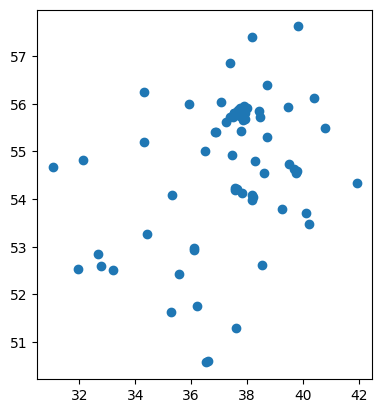

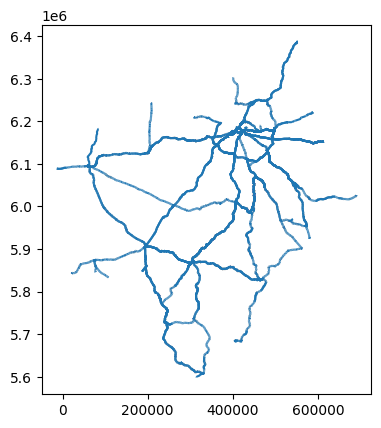

In [65]:
# График станций
shape2 = aggregated_data
shapefile.plot()
plt.show()

# График путей
shape2.plot()
plt.show()

In [66]:
aggregated_data['length_km'] = aggregated_data['geometry'].length / 1000

print(aggregated_data[['origin','destinatio','geometry', 'length_km', "maxspeed"]])

                    origin                     destinatio  \
0       Александро-Невская                         Рыбное   
1   Бекасово-Сортировочное                        Вековка   
2   Бекасово-Сортировочное          Люблино-Сортировочное   
3   Бекасово-Сортировочное                  Малоярославец   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская   
..                     ...                            ...   
75                   Унеча                       Стародуб   
76                 Фрязево                        Ногинск   
77                 Щёлково               Лосиноостровская   
78       Ярославль-Главный               Лосиноостровская   
79       Ярославль-Главный                  Орехово-Зуево   

                                             geometry   length_km   maxspeed  
0   MULTILINESTRING ((580388.745 5926227.814, 5804...  207.117385  80.000000  
1   MULTILINESTRING ((589802.650 6148604.962, 5897...  409.087282  97.560538  
2   MULTILINESTRING ((420474.2

Импорт тренировочного датасета, который состоит из времени поезда в пути и пунктов прибытия и отбытия.

In [67]:
train_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_external.csv")
train_df

,index,value,route_start,route_end
0,1198,4.150000,Кусково,Яничкино
1,2983,14.300000,Вековка,Курск
2,3418,7.116667,Люблино-Сортировочное,Рязань-2
3,1955,20.333333,Красное,Погар
4,1697,13.900000,Белгород,Елец
...,...,...,...,...
1514,2424,10.683333,Люберцы II,Волоколамск
1515,1364,9.166667,Волоколамск,Вековка
1516,1419,10.866667,Перово,Елец
1517,1723,9.483333,Волоколамск,Узуново


Создание графа, на котором будет обучаться сетка.

In [68]:
all_routes = aggregated_data

# Граф для расстояний (кратчайшее по расстоянию)
G = nx.Graph()

# Добавляем узлы в виде станций
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
G.add_nodes_from(stations)

# Добавляем ребра в виде расстояний между пунктами
for index, row in all_routes.iterrows():
    G.add_edge(row['origin'], row['destinatio'], weight=row['length_km'])
    # У нас есть переменная reverced, которая должна сделать граф ориентированным
    G.add_edge(row['destinatio'], row['origin'], weight=row['length_km'])

# Ищем самый дешевый путь с точки зрения часов
F = nx.Graph()

stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
F.add_nodes_from(stations)
for index, row in all_routes.iterrows():
    F.add_edge(row['origin'], row['destinatio'], weight=row['length_km']/row['maxspeed'])
    # Assuming undirected graph, add the reverse edge
    F.add_edge(row['destinatio'], row['origin'], weight=row['length_km']/row['maxspeed']) 

In [69]:
# Функция поиска кратчайшего пути между начальной и конечной станциями
def find_shortest_path(start_station, end_station):
    try:
        if not(start_station in G and end_station in G):
            return 0,0,0
        else:
            shortest_path = nx.shortest_path(G, start_station, end_station, weight='weight')
            shortest_distance = nx.shortest_path_length(G, start_station, end_station, weight='weight')
            num_stations = len(shortest_path) - 1
            return shortest_path, shortest_distance, num_stations
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf')  # No path found


def find_fastest_path(start_station, end_station):
    try:
        if not(start_station in F and end_station in F):
            return 0,0,0
        else:
            fastest_path = nx.dijkstra_path(F, start_station, end_station, weight='weight')
            fastest_distance = nx.dijkstra_path_length(F, start_station, end_station, weight='weight')
            num_stations_fast = len(fastest_path) - 1
            return fastest_path, fastest_distance, num_stations_fast
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf')  # No path found
    
    
for index, row in train_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    fastest_path, fastest_distance, num_stations_fast = find_fastest_path(start_station, end_station)
    
    if shortest_path:
        train_df.at[index, 'optimal_distance_km'] = shortest_distance
        train_df.at[index, 'num_stations'] = num_stations
    else:
        train_df.at[index, 'optimal_distance_km'] = 0  # or any default value for no path found
        train_df.at[index, 'num_stations'] = 0
    if fastest_path:
        train_df.at[index, 'optimal_distance_hours'] = fastest_distance
        train_df.at[index, 'num_stations_fast'] = num_stations_fast
    else:
        train_df.at[index, 'optimal_distance_hours'] = 0
        train_df.at[index, 'num_stations_fast'] = 0
print(train_df)

      index      value            route_start    route_end  \
0      1198   4.150000                Кусково     Яничкино   
1      2983  14.300000                Вековка        Курск   
2      3418   7.116667  Люблино-Сортировочное     Рязань-2   
3      1955  20.333333                Красное        Погар   
4      1697  13.900000               Белгород         Елец   
...     ...        ...                    ...          ...   
1514   2424  10.683333             Люберцы II  Волоколамск   
1515   1364   9.166667            Волоколамск      Вековка   
1516   1419  10.866667                 Перово         Елец   
1517   1723   9.483333            Волоколамск      Узуново   
1518   1006   6.466667               Рязань-2       Перово   

      optimal_distance_km  num_stations  optimal_distance_hours  \
0              268.887101           2.0                2.755755   
1             1166.548994           5.0               12.313901   
2              314.678247           2.0               

Загружаем тестовый датасет:

In [70]:
test_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")

In [71]:
# Поиск кратчайших путей на графе
for index, row in test_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    fastest_path, fastest_distance, num_stations_fast = find_fastest_path(start_station, end_station)
    
    if shortest_path:
        test_df.at[index, 'optimal_distance_km'] = shortest_distance
        test_df.at[index, 'num_stations'] = num_stations
    else:
        test_df.at[index, 'optimal_distance_km'] = 0  # or any default value for no path found
        test_df.at[index, 'num_stations'] = 0
    if fastest_path:
        test_df.at[index, 'optimal_distance_hours'] = fastest_distance
        test_df.at[index, 'num_stations_fast'] = num_stations_fast
    else:
        test_df.at[index, 'optimal_distance_hours'] = 0
        test_df.at[index, 'num_stations_fast'] = 0

# Print updated train_df
print(test_df)

      index                 route_start               route_end  \
0      2623                      Вязьма                 Щёлково   
1      4413                    Аэропорт                   Лесок   
2       480                     Узуново           Малоярославец   
3      4409                    Серпухов                   Лесок   
4      9286                  Кунцево II                 Петушки   
...     ...                         ...                     ...   
1514   1676                        Елец                  Перово   
1515   8047                 Зелёный Бор                 Вековка   
1516     37  Москва-Товарная-Смоленская            Курбакинская   
1517   1179      Смоленск-Сортировочный                Владимир   
1518   8020                    Аэропорт  Бекасово-Сортировочное   

      optimal_distance_km  num_stations  optimal_distance_hours  \
0              757.835709           4.0                7.601179   
1                0.000000           0.0                0.0000

## Построение предсказательной модели

In [72]:
X = train_df.drop(columns=['value', 'route_start', 'route_end'])
y = train_df['value']

# Разбиваем выборку на тренировочную и тестовую
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.0001, random_state=42)

In [73]:
catboost_params = {
    'iterations': 1500,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',
    'l2_leaf_reg': 3,
    'leaf_estimation_iterations': 10,
    'random_seed': 42
}

train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

# Запускаем кросс-валидацию
cv_results = cv(pool=train_pool,
                params=catboost_params,
                fold_count=5,  
                verbose=100,  
                plot=True)  

best_iteration = len(cv_results)

print(f"Best RMSE: {cv_results['test-RMSE-mean'].min():.2f} ± {cv_results['test-RMSE-std'].mean():.2f} at iteration {best_iteration}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 10.8700498	test: 11.2622504	best: 11.2622504 (0)	total: 9.41ms	remaining: 9.4s
100:	learn: 2.2411030	test: 2.9048698	best: 2.8978199 (91)	total: 606ms	remaining: 5.39s
200:	learn: 1.8209798	test: 2.8809675	best: 2.8715267 (193)	total: 1.29s	remaining: 5.14s
300:	learn: 1.5579781	test: 2.8548908	best: 2.8545317 (299)	total: 1.99s	remaining: 4.61s
400:	learn: 1.3499325	test: 2.8629984	best: 2.8514550 (311)	total: 2.66s	remaining: 3.97s
500:	learn: 1.1966612	test: 2.8647986	best: 2.8514550 (311)	total: 3.41s	remaining: 3.39s
600:	learn: 1.0695389	test: 2.8665620	best: 2.8514550 (311)	total: 4.13s	remaining: 2.74s
700:	learn: 0.9628640	test: 2.8775442	best: 2.8514550 (311)	total: 4.84s	remaining: 2.06s
800:	learn: 0.8801373	test: 2.8858457	best: 2.8514550 (311)	total: 5.54s	remaining: 1.38s
900:	learn: 0.8075269	test: 2.9032008	best: 2.8514550 (311)	total: 6.26s	remaining: 687ms
999:	learn: 0.7501628	test: 2.9245559	best: 2.8514550 (311)	total: 6.93s	remain

In [74]:
# CatBoostRegressor с лучшими параметрами
best_model = CatBoostRegressor(iterations=best_iteration,
                               learning_rate=0.1,
                               depth=10,
                               loss_function='RMSE',
                               random_seed=42)

best_model.fit(X, y, verbose=100)

0:	learn: 4.3720453	total: 8.42ms	remaining: 8.41s
100:	learn: 2.2658790	total: 671ms	remaining: 5.97s
200:	learn: 1.8859311	total: 1.41s	remaining: 5.62s
300:	learn: 1.6651496	total: 2.12s	remaining: 4.93s
400:	learn: 1.4981381	total: 2.81s	remaining: 4.2s
500:	learn: 1.3747290	total: 3.5s	remaining: 3.49s
600:	learn: 1.2706533	total: 4.22s	remaining: 2.8s
700:	learn: 1.1914427	total: 4.92s	remaining: 2.1s
800:	learn: 1.1246776	total: 5.6s	remaining: 1.39s
900:	learn: 1.0696768	total: 6.29s	remaining: 691ms
999:	learn: 1.0237946	total: 6.97s	remaining: 0us


Метрики:

In [75]:
y_pred = best_model.predict(X_val)
# Считаем RMSE и MAE
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.2f} kilometers")
print(f"MAE: {mae:.2f} kilometers")


RMSE: 0.13 kilometers
MAE: 0.13 kilometers


Предсказания:

In [76]:
test_pred = best_model.predict(test_df.drop(columns=['route_start', 'route_end']))
print(test_pred)

[10.94497374 10.4755685   8.9675298  ... 10.35114101  8.50903002
  6.10747515]


In [77]:
test_df["value"] = test_pred

In [78]:
test_df

,index,route_start,route_end,optimal_distance_km,num_stations,optimal_distance_hours,num_stations_fast,value
0,2623,Вязьма,Щёлково,757.835709,4.0,7.601179,4.0,10.944974
1,4413,Аэропорт,Лесок,0.000000,0.0,0.000000,0.0,10.475568
2,480,Узуново,Малоярославец,438.417927,4.0,5.088348,4.0,8.967530
3,4409,Серпухов,Лесок,433.693874,3.0,4.451626,3.0,6.970832
4,9286,Кунцево II,Петушки,716.954299,5.0,7.347806,5.0,13.443082
...,...,...,...,...,...,...,...,...
1514,1676,Елец,Перово,0.000000,0.0,0.000000,0.0,9.817850
1515,8047,Зелёный Бор,Вековка,454.405937,3.0,4.830757,3.0,7.348612
1516,37,Москва-Товарная-Смоленская,Курбакинская,703.990153,4.0,7.446735,4.0,10.351141
1517,1179,Смоленск-Сортировочный,Владимир,941.980834,4.0,8.547603,4.0,8.509030
